In [1]:
import os
import sys
sys.path.append("C:/Users/PC-EIAD209/Desktop/AnaKei/NIPD-AI")
#sys.path.append("C:\\Users\\"+os.getlogin()+"\\OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey\\PainClassifier")
from my_data_generator import *

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import h5py
import warnings
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_fscore_support as score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from datetime import datetime
import scipy as sp
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import auc, roc_curve
from itertools import cycle
from sklearn.metrics import RocCurveDisplay
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Conv3D, MaxPooling3D, Flatten, Dropout, GlobalAveragePooling3D, concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
from tensorflow.keras.applications.vgg16 import VGG16


#from keras.regularizers import l2
import cv2
#from keras import initializers
#from keras.layers import LeakyReLU
#from keras.layers import BatchNormalization
import tensorflow as tf
#from keras import losses

#nuevo
from tensorflow.keras.regularizers import l2
from tensorflow.keras import initializers, losses
from tensorflow.keras.layers import LeakyReLU, BatchNormalization


from tensorflow.keras.optimizers import SGD
import wandb
from wandb.integration.keras import WandbCallback
import gc
#from numba import cuda   nota: no se usa
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import nibabel as nib


In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [4]:
rabies_ref_path= r"F:/rabies/preprocess_batch-001/commonspace_bold/_scan_info_subject_id003.session01_split_name_sub-003_ses-01_desc-o_T2w/_run_None/sub-003_ses-01_task-dist_desc-oa_bold_autobox_combined.nii.gz"
rabies_ref = nib.load(rabies_ref_path).get_fdata()
rabies_vol= np.mean(rabies_ref, axis=3)
print("rabies_ref shape:", rabies_ref.shape)

rabies_ref shape: (48, 81, 48, 620)


In [5]:
# Mixed precision training

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('float32')

#DirectML no se lleva com mixedfloat16
#mixed_precision.set_global_policy('mixed_float16')

In [6]:
def VGG16_3D(blocks):
        
    inputs = Input(shape=(42, 65, 29), name='input_layer')
    x = Reshape(target_shape=[42, 65, 29, 1], name='input_x_3d_volumes')(inputs)

    if blocks == 1:
        print("entra al 1")
        #batch_norm
        x = BatchNormalization()(x)
        # 1st Conv Block
        x = Conv3D(filters =64, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = Conv3D(filters =64, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = MaxPooling3D(pool_size =2, strides =2, padding ='same')(x)
        x = tf.keras.layers.GlobalAveragePooling3D()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        
    elif blocks == 2:
        print("entra al 2")
        #batch_norm
        x = BatchNormalization()(x)
        # 1st Conv Block
        x = Conv3D(filters =64, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = Conv3D(filters =64, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = MaxPooling3D(pool_size =2, strides =2, padding ='same')(x)
        x = tf.keras.layers.Dropout(0.2)(x)
            
        #batch_norm
        x = BatchNormalization()(x)
        # 2nd Conv Block
        x = Conv3D (filters =128, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = Conv3D (filters =128, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = MaxPooling3D(pool_size =2, strides =2, padding ='same')(x)
        x = tf.keras.layers.GlobalAveragePooling3D()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        
    elif blocks == 3:
        print("entra al 3")
        #batch_norm
        x = BatchNormalization()(x)
        # 1st Conv Block
        x = Conv3D(filters =64, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = Conv3D(filters =64, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = MaxPooling3D(pool_size =2, strides =2, padding ='same')(x)
        x = tf.keras.layers.Dropout(0.2)(x)
            
        #batch_norm
        x = BatchNormalization()(x)
        # 2nd Conv Block
        x = Conv3D (filters =128, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = Conv3D (filters =128, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = MaxPooling3D(pool_size =2, strides =2, padding ='same')(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        
        #batch_norm
        x = BatchNormalization()(x)
        # 3rd Conv block  
        x = Conv3D (filters =256, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x) 
        x = Conv3D (filters =256, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x) 
        x = Conv3D (filters =256, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x) 
        x = MaxPooling3D(pool_size =2, strides =2, padding ='same')(x)
        x = tf.keras.layers.GlobalAveragePooling3D()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        
    elif blocks == 4:
        print("entra al 4")
        #batch_norm
        x = BatchNormalization()(x)
        # 1st Conv Block
        x = Conv3D(filters =64, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = Conv3D(filters =64, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = MaxPooling3D(pool_size =2, strides =2, padding ='same')(x)
        x = tf.keras.layers.Dropout(0.2)(x)
            
        #batch_norm
        x = BatchNormalization()(x)
        # 2nd Conv Block
        x = Conv3D (filters =128, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = Conv3D (filters =128, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        #x = MaxPooling3D(pool_size =2, strides =2, padding ='same')(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        
        #batch_norm
        x = BatchNormalization()(x)
        # 3rd Conv block  
        x = Conv3D (filters =256, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x) 
        x = Conv3D (filters =256, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x) 
        x = Conv3D (filters =256, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x) 
        #x = MaxPooling3D(pool_size =2, strides =2, padding ='same')(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        
        #batch_norm
        x = BatchNormalization()(x)
        # 4th Conv block
        x = Conv3D (filters =512, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = Conv3D (filters =512, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = Conv3D (filters =512, kernel_size =3, padding ='same', activation='relu',kernel_regularizer='l2')(x)
        x = MaxPooling3D(pool_size =2, strides =2, padding ='same')(x)
        #x = tf.keras.layers.GlobalAveragePooling3D()(x)
        x = tf.keras.layers.Dropout(0.5)(x)

    elif blocks == 5:
        print("entra al 5")
        #batch_norm
        #x = BatchNormalization()(x)
        # 1st Conv Block
        x = Conv3D(filters =64, kernel_size =3, padding ='same', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.001))(x)
        x = Conv3D(filters =64, kernel_size =3, padding ='same', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.001))(x)
        x = BatchNormalization()(x)
        x = MaxPooling3D(pool_size =2, strides =2, padding ='same')(x)
        x = tf.keras.layers.Dropout(0.1)(x)
            
        #batch_norm
        #x = BatchNormalization()(x)
        # 2nd Conv Block
        x = Conv3D (filters =128, kernel_size =3, padding ='same', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.001))(x)
        x = Conv3D (filters =128, kernel_size =3, padding ='same', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.001))(x)
        x = BatchNormalization()(x)
        #x = MaxPooling3D(pool_size =2, strides =1, padding ='same')(x)
        x = tf.keras.layers.Dropout(0.1)(x)
        
        #batch_norm
        #x = BatchNormalization()(x)
        # 3rd Conv block  
        x = Conv3D (filters =256, kernel_size =3, padding ='same', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.001))(x) 
        x = Conv3D (filters =256, kernel_size =3, padding ='same', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.001))(x) 
        x = Conv3D (filters =256, kernel_size =3, padding ='same', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.001))(x) 
        x = BatchNormalization()(x)
        #x = MaxPooling3D(pool_size =2, strides =1, padding ='same')(x)
        x = tf.keras.layers.Dropout(0.1)(x)
        
        #batch_norm
        #x = BatchNormalization()(x)
        # 4th Conv block
        x = Conv3D (filters =512, kernel_size =3, padding ='same', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.001))(x)
        x = Conv3D (filters =512, kernel_size =3, padding ='same', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.001))(x)
        x = Conv3D (filters =512, kernel_size =3, padding ='same', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.001))(x)
        x = BatchNormalization()(x)
        #x = MaxPooling3D(pool_size =2, strides =1, padding ='same')(x)
        x = tf.keras.layers.Dropout(0.1)(x)
    
        #batch_norm
        #x = BatchNormalization()(x)
        # 5th Conv block
        x = Conv3D (filters =512, kernel_size =3, padding ='same', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.001))(x)
        x = Conv3D (filters =512, kernel_size =3, padding ='same', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.001))(x)
        x = Conv3D (filters =512, kernel_size =3, padding ='same', activation='relu',kernel_regularizer=tf.keras.regularizers.L2(l2=0.001))(x)
        x = BatchNormalization()(x)
        #x = MaxPooling3D(pool_size =2, strides =2, padding ='same')(x)
        x = tf.keras.layers.GlobalAveragePooling3D()(x)
        x = tf.keras.layers.Dropout(0.1)(x)
    
    # Fully connected layers  
    x = Flatten()(x) 
    x = Dense(units = 1024, activation ='relu',kernel_regularizer='l2')(x)
    #x = tf.keras.layers.Dropout(0.5)(x)
    x = Dense(units = 1024, activation ='relu',kernel_regularizer='l2')(x) 
    x = tf.keras.layers.Dropout(0.3)(x)
    output = Dense(units = 2,activation ='softmax',kernel_regularizer='l2')(x)
    
    # creating the model
    VGG_3d_model = Model (inputs=inputs, outputs =output)
    #model.summary()

    return VGG_3d_model

def set_pretrained_weigths(VGG_3d_model):
    #VGG 16 with weights from Imagenet
    pretrained_model = tf.keras.applications.VGG16(
        include_top=False,
        weights="imagenet",
        pooling='avg',
        input_shape = (42, 65, 3)
    )
    
    #conv layers on VGG_3d_model
    layers_conv = []
    for j in range(len(VGG_3d_model.layers)):
        if "conv3d" in str(VGG_3d_model.layers[j]):
            layers_conv.append(j)
    layers_conv_pretrained = []
    for j in range(len(pretrained_model.layers)):
        if "Conv2D" in str(pretrained_model.layers[j]):
            layers_conv_pretrained.append(j)
    
    for i in range(len(layers_conv)):
        if "Conv2D" in str(pretrained_model.layers[layers_conv_pretrained[i]]):
            if i == 0:
                w = pretrained_model.layers[layers_conv_pretrained[i]].get_weights()[0].sum(axis=2, keepdims=True)
            else:
                w = pretrained_model.layers[layers_conv_pretrained[i]].get_weights()[0]
                
            w3d=[]
            
            w = np.reshape(w,(3,3,-1),order='F')
            for j in range(len(w[0,0,:])):
                for k in range(3):
                    w3d.append(w[:,:,j])
            w3d = np.transpose(w3d, (1,2,0))
            
            new_weights = np.reshape(w3d, np.array(VGG_3d_model.layers[layers_conv[i]].get_weights()[0]).shape,order='F')
            new_bias = pretrained_model.layers[layers_conv_pretrained[i]].get_weights()[1]
            
            WnB = []
            WnB.append(new_weights)
            WnB.append(new_bias)
    
            VGG_3d_model.layers[layers_conv[i]].set_weights(WnB)

    del pretrained_model, w, WnB, new_weights, new_bias, w3d

In [7]:
def confusionmatrix_multiclass(y_test,pred):
    cm = confusion_matrix(y_test, (np.rint(preds)).astype(int) )
    group_names = ['True baseline','False Baseline','False Baseline',   
                   'False week 1','Truec','False Week 1',
                  'False week 7','False week 7','True week 7']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         np.ndarray.flatten(cm/(np.sum(cm,axis=1).reshape(3,1)))]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(3,3)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels = ['Baseline','Week 1','Week 7'] ,yticklabels = ['Baseline','Week 1','Week 7'])
    plt.show()

def confusionmatrix(y_test,preds):
    #Construct the Confusion Matrix
    cm = confusion_matrix(y_test, preds)
    group_names = ['True Male','False Male','False Female','True Female']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         np.ndarray.flatten(cm/(np.sum(cm,axis=1).reshape(2,1)))]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels = ['MALE','FEMALE'] ,yticklabels = ['MALE','FEMALE'])
    plt.show()
    return sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels = ['MALE','FEMALE'] ,yticklabels = ['MALE','FEMALE'])
    
def confusionmatrix_binary(y_test, preds):
    cm = confusion_matrix(y_test, preds)
    group_names = ['True baseline','False baseline','False Week 1','True Week 1']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         np.ndarray.flatten(cm/(np.sum(cm,axis=1).reshape(2,1)))]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels = ['MALE','FEMALE'] ,yticklabels = ['MALE','FEMALE'])
    plt.show()

def ROC(probs,y_test): #binary
    #Classification Area under curve
     warnings.filterwarnings('ignore')
             
     auc = roc_auc_score(y_test, probs)
     print('AUC - Test Set: %.2f%%' % (auc*100))
    
     # calculate roc curve
     fpr, tpr, thresholds = roc_curve(y_test, probs)
     # plot no skill
     plt.plot([0, 1], [0, 1], linestyle='--')
     # plot the roc curve for the model
     plt.plot(fpr, tpr, marker='.')
     plt.xlabel('False positive rate')
     plt.ylabel('Sensitivity/ Recall')
     # show the plot
     plt.show()
    
     probs = (np.rint(probs)).astype(int)   
        
     precision = precision_score(y_test, probs)
     print('Precision: %f' % precision)
     # recall: tp / (tp + fn)
     recall = recall_score(y_test, probs)
     print('Recall: %f' % recall)
     # f1: tp / (tp + fp + fn)
     f1 = f1_score(y_test, probs)
     print('F1 score: %f' % f1)
        
def ROC_multiclass(model, y_test, n_class):
    #y_test: array size (# of subjects, ) with classes 
    #pretrained model to be evaluated 
    
    label_binarizer = LabelBinarizer().fit(y_test)
    y_onehot_test = label_binarizer.transform(y_test)
    y_onehot_test.shape  # (n_samples, n_classes)

    y_score = model.predict(X_test) # y_score is onehot
    
    # store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")
    
    n_classes = n_class
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")
    
    target_names = ['Naive','Week1','Week7']

    fig, ax = plt.subplots(figsize=(6, 6))

    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_score[:, class_id],
            name=f"ROC curve for {target_names[class_id]}",
            color=color,
            ax=ax,
            plot_chance_level=(class_id == 2),
        )

    _ = ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass",
    )
    
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    c = ['b','g','r','c','m','y','k','w']
    ltr = ['fold 1(train)','fold 2(train)','fold 3(train)','fold 4(train)','fold 5(train)']
    lts = ['fold 1(val)','fold 2(val)','fold 3(val)','fold 4(val)','fold 5(val)']
    for i in range(len(histories)):
        # plot loss
        plt.subplot(2, 1, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color=c[i], label=ltr[i], linestyle="-")
        plt.plot(histories[i].history['val_loss'], color=c[i], label=lts[i], linestyle="--")
        # plot accuracy
        plt.subplot(2, 1, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['Accuracy'], color=c[i], label=ltr[i], linestyle="-")
        plt.plot(histories[i].history['val_Accuracy'], color=c[i], label=lts[i], linestyle="--")
    plt.legend()
    plt.show()

# summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (np.mean(scores)*100, np.std(scores)*100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show() 

# Just Brain Male-BL vs Female-BL 

In [8]:

male = [57, 
        #59,
        60,73,74,93,94,95,96,98,99,100]
female = [49,50,51,52,65,66,77,78,79,80,81,82,
          #83
         ]
         

#male = [57,60,73,74,93,]
#female = [49,50,51,52]

y_male = np.ones(len(male))
y_female = np.zeros(len(female))

subjects = np.array(male+female)
labels = np.array(list(y_male)+list(y_female))
sessions = [1]
MRI_type = "func"
functional_type = "dist"

#Pretrained model to re start weights from at every fold
baseModel = VGG16_3D(5)
set_pretrained_weigths(baseModel)

#Model that is going to be train and re started every fold
CNN = VGG16_3D(5)


entra al 5
entra al 5



=== Bootstrapping Run 1/1 ===
Run # 1


wandb: Currently logged in as: a01067716 (a01067716-tecnol-gico-de-monterrey) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


sub train:
['F:/rabies/preprocess_batch-002/commonspace_bold/_scan_info_subject_id079.session01_split_name_sub-079_ses-01_desc-o_T2w/_run_None/sub-079_ses-01_task-dist_desc-oa_bold_autobox_combined.nii.gz'
 'F:/rabies/preprocess_batch-002/commonspace_bold/_scan_info_subject_id100.session01_split_name_sub-100_ses-01_desc-o_T2w/_run_None/sub-100_ses-01_task-dist_desc-oa_bold_autobox_combined.nii.gz'
 'F:/rabies/preprocess_batch-001/commonspace_bold/_scan_info_subject_id057.session01_split_name_sub-057_ses-01_desc-o_T2w/_run_None/sub-057_ses-01_task-dist_desc-oa_bold_autobox_combined.nii.gz'
 'F:/rabies/preprocess_batch-002/commonspace_bold/_scan_info_subject_id080.session01_split_name_sub-080_ses-01_desc-o_T2w/_run_None/sub-080_ses-01_task-dist_desc-oa_bold_autobox_combined.nii.gz'
 'F:/rabies/preprocess_batch-002/commonspace_bold/_scan_info_subject_id074.session01_split_name_sub-074_ses-01_desc-o_T2w/_run_None/sub-074_ses-01_task-dist_desc-oa_bold_autobox_combined.nii.gz'
 'F:/rabies/pr

wandb: WARNING WandbCallback is deprecated and will be removed in a future release. Please use the WandbMetricsLogger, WandbModelCheckpoint, and WandbEvalCallback callbacks instead. See https://docs.wandb.ai/guides/integrations/keras for more information.


Epoch 1/15
209/209 [==============================] - ETA: 0s - loss: 21.1737 - Accuracy: 0.9904 

INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\vocal-cherry-16\assets


INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\vocal-cherry-16\assets


209/209 [==============================] - 10785s 52s/step - loss: 21.1737 - Accuracy: 0.9904 - val_loss: 20.0158 - val_Accuracy: 1.0000
Epoch 2/15
209/209 [==============================] - ETA: 0s - loss: 18.9974 - Accuracy: 1.0000 

INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\vocal-cherry-16\assets


INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\vocal-cherry-16\assets


209/209 [==============================] - 10799s 52s/step - loss: 18.9974 - Accuracy: 1.0000 - val_loss: 18.0011 - val_Accuracy: 1.0000
Epoch 3/15
209/209 [==============================] - ETA: 0s - loss: 17.0199 - Accuracy: 1.0000 

INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\vocal-cherry-16\assets


INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\vocal-cherry-16\assets


209/209 [==============================] - 10799s 52s/step - loss: 17.0199 - Accuracy: 1.0000 - val_loss: 16.1334 - val_Accuracy: 0.9982
Epoch 4/15
209/209 [==============================] - ETA: 0s - loss: 15.1899 - Accuracy: 1.0000 

INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\vocal-cherry-16\assets


INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\vocal-cherry-16\assets


209/209 [==============================] - 10807s 52s/step - loss: 15.1899 - Accuracy: 1.0000 - val_loss: 14.3924 - val_Accuracy: 0.9965
Epoch 5/15
209/209 [==============================] - ETA: 0s - loss: 13.5226 - Accuracy: 1.0000 

INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\vocal-cherry-16\assets


INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\vocal-cherry-16\assets


209/209 [==============================] - 10793s 52s/step - loss: 13.5226 - Accuracy: 1.0000 - val_loss: 12.7686 - val_Accuracy: 1.0000
Epoch 6/15
209/209 [==============================] - ETA: 0s - loss: 12.0186 - Accuracy: 1.0000 

INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\vocal-cherry-16\assets


INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\vocal-cherry-16\assets


209/209 [==============================] - 10797s 52s/step - loss: 12.0186 - Accuracy: 1.0000 - val_loss: 11.5377 - val_Accuracy: 0.9211
Epoch 7/15
209/209 [==============================] - ETA: 0s - loss: 10.6797 - Accuracy: 1.0000 

INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\vocal-cherry-16\assets


INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\vocal-cherry-16\assets


209/209 [==============================] - 10774s 51s/step - loss: 10.6797 - Accuracy: 1.0000 - val_loss: 10.1093 - val_Accuracy: 0.9982
Epoch 8/15
209/209 [==============================] - ETA: 0s - loss: 9.5122 - Accuracy: 1.0000 

INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\vocal-cherry-16\assets


INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\vocal-cherry-16\assets


209/209 [==============================] - 10783s 51s/step - loss: 9.5122 - Accuracy: 1.0000 - val_loss: 9.9947 - val_Accuracy: 0.5974
Epoch 9/15
209/209 [==============================] - ETA: 0s - loss: 8.4930 - Accuracy: 1.0000 

INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\vocal-cherry-16\assets


INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\vocal-cherry-16\assets


209/209 [==============================] - 10802s 52s/step - loss: 8.4930 - Accuracy: 1.0000 - val_loss: 8.3630 - val_Accuracy: 0.7825
Epoch 10/15
209/209 [==============================] - ETA: 0s - loss: 7.5746 - Accuracy: 1.0000 

INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\vocal-cherry-16\assets


INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\vocal-cherry-16\assets


209/209 [==============================] - 10808s 52s/step - loss: 7.5746 - Accuracy: 1.0000 - val_loss: 7.2467 - val_Accuracy: 0.9675
Epoch 11/15
209/209 [==============================] - ETA: 0s - loss: 6.7475 - Accuracy: 1.0000 

INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\vocal-cherry-16\assets


INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\vocal-cherry-16\assets


209/209 [==============================] - 10803s 52s/step - loss: 6.7475 - Accuracy: 1.0000 - val_loss: 6.3627 - val_Accuracy: 1.0000
Epoch 12/15
209/209 [==============================] - ETA: 0s - loss: 5.9991 - Accuracy: 1.0000 

INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\vocal-cherry-16\assets


INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\vocal-cherry-16\assets


209/209 [==============================] - 10816s 52s/step - loss: 5.9991 - Accuracy: 1.0000 - val_loss: 5.7523 - val_Accuracy: 0.9614
Epoch 13/15
209/209 [==============================] - ETA: 0s - loss: 5.3253 - Accuracy: 1.0000 

INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\vocal-cherry-16\assets


INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\vocal-cherry-16\assets


209/209 [==============================] - 10814s 52s/step - loss: 5.3253 - Accuracy: 1.0000 - val_loss: 5.0202 - val_Accuracy: 1.0000
Epoch 14/15
209/209 [==============================] - ETA: 0s - loss: 4.7207 - Accuracy: 1.0000 

INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\vocal-cherry-16\assets


INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\vocal-cherry-16\assets


209/209 [==============================] - 10805s 52s/step - loss: 4.7207 - Accuracy: 1.0000 - val_loss: 4.4820 - val_Accuracy: 0.9982
Epoch 15/15
209/209 [==============================] - ETA: 0s - loss: 4.1804 - Accuracy: 1.0000 

INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\vocal-cherry-16\assets


INFO:tensorflow:Assets written to: c:\Users\PC-EIAD209\Desktop\AnaKei\NIPD-AI\vocal-cherry-16\assets


209/209 [==============================] - 10796s 52s/step - loss: 4.1804 - Accuracy: 1.0000 - val_loss: 4.0523 - val_Accuracy: 0.9561
Duration (CNN): 1 day, 21:00:01.198064
predicts CNN
95/95 [==============================] - 938s 10s/step
mislabeled subjects:
 Counter({'F:/rabies/preprocess_batch-002/commonspace_bold/_scan_info_subject_id073.session01_split_name_sub-073_ses-01_desc-o_T2w/_run_None/sub-073_ses-01_task-dist_desc-oa_bold_autobox_combined.nii.gz': 563, 'F:/rabies/preprocess_batch-001/commonspace_bold/_scan_info_subject_id049.session01_split_name_sub-049_ses-01_desc-o_T2w/_run_None/sub-049_ses-01_task-dist_desc-oa_bold_autobox_combined.nii.gz': 416, 'F:/rabies/preprocess_batch-002/commonspace_bold/_scan_info_subject_id078.session01_split_name_sub-078_ses-01_desc-o_T2w/_run_None/sub-078_ses-01_task-dist_desc-oa_bold_autobox_combined.nii.gz': 5})
evaluating CNN
95/95 [==============================] - 949s 10s/step - loss: 4.5192 - Accuracy: 0.6547
GradCam All ConvLayers-m

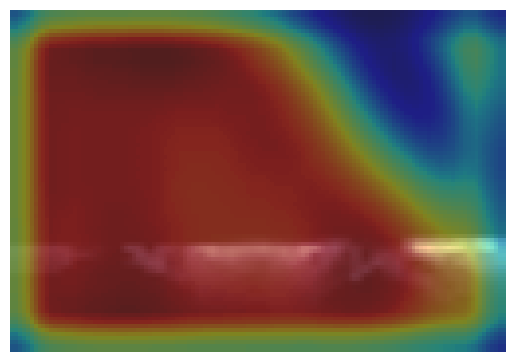

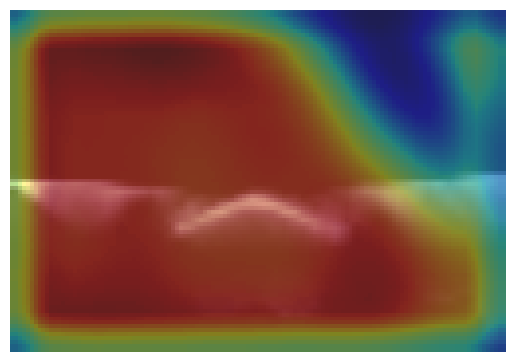

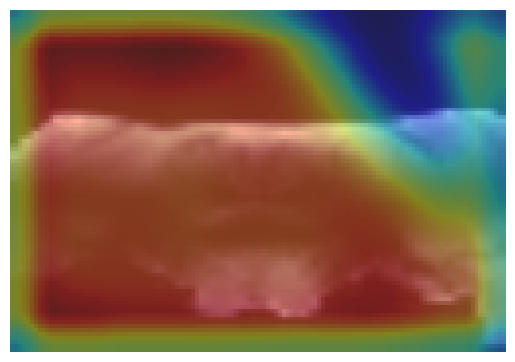

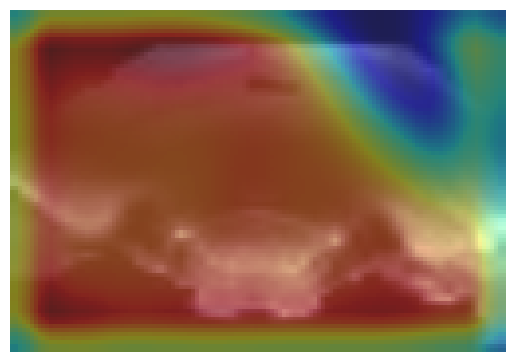

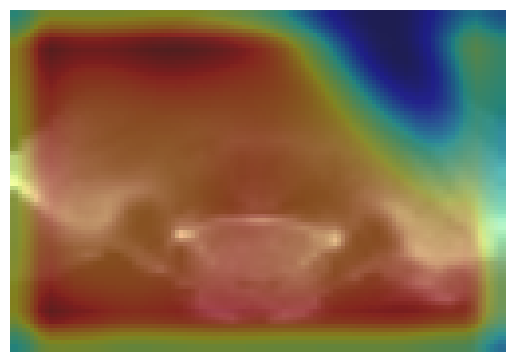

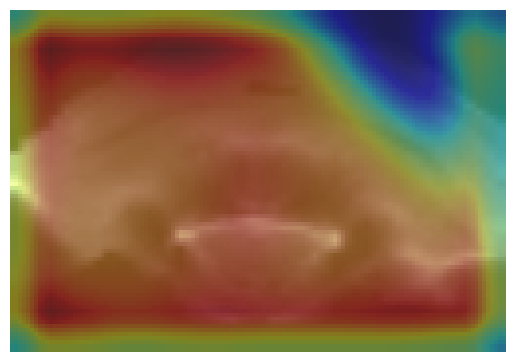

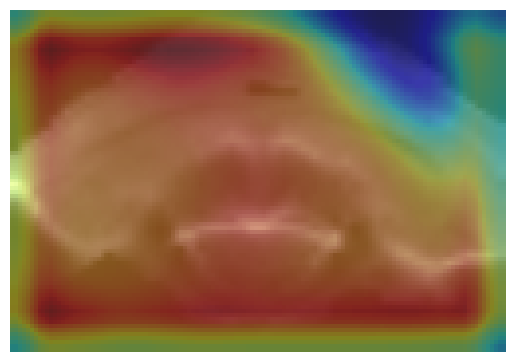

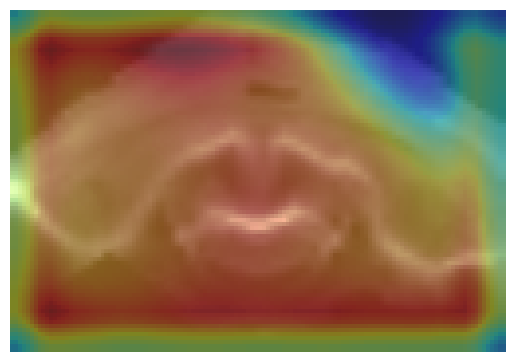

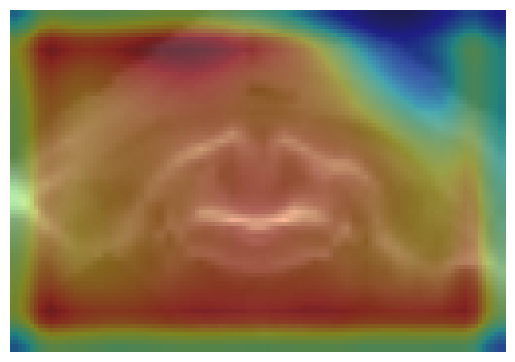

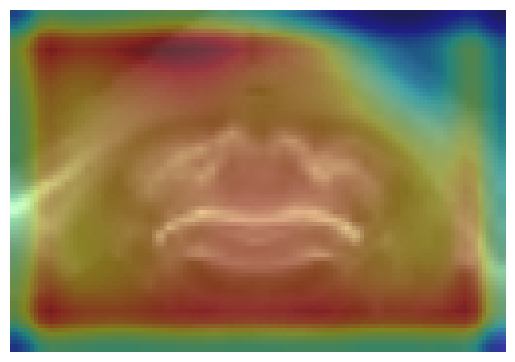

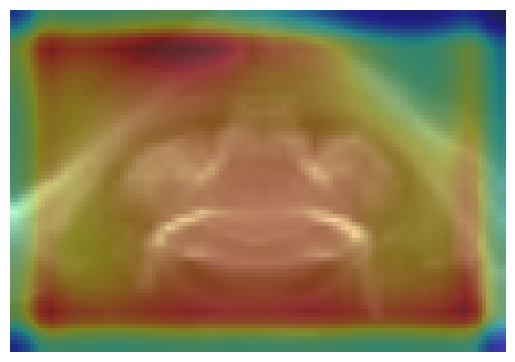

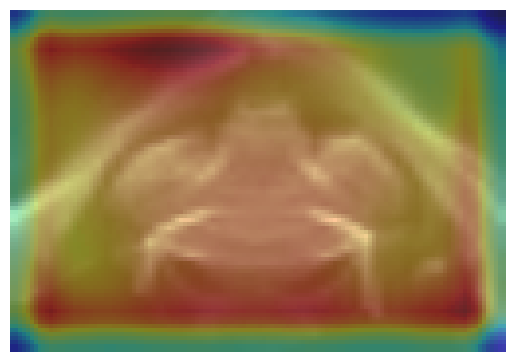

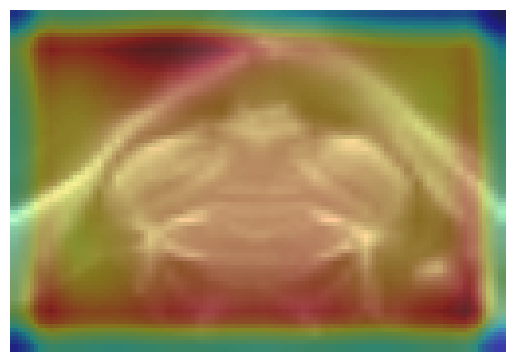

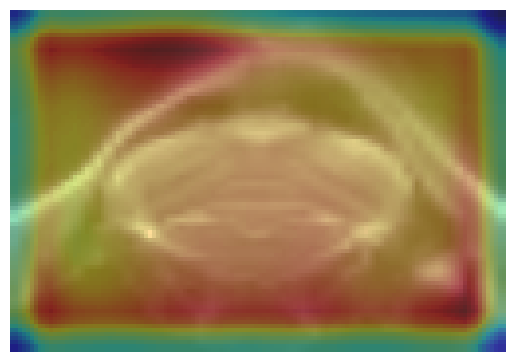

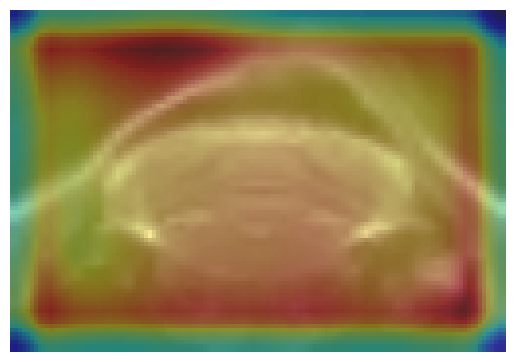

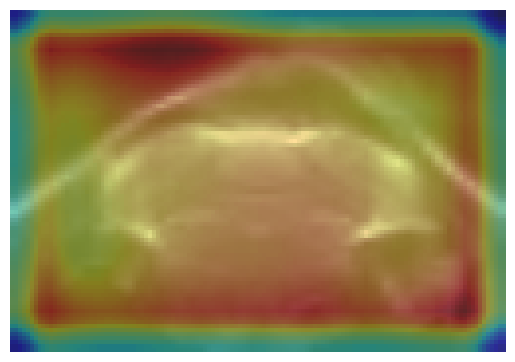

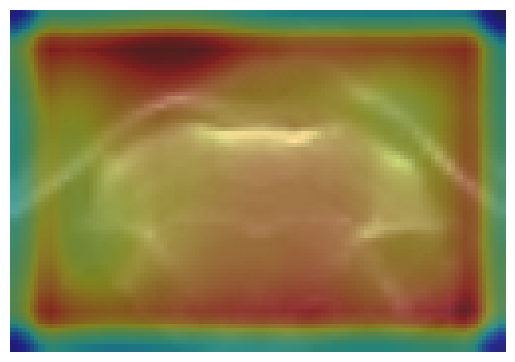

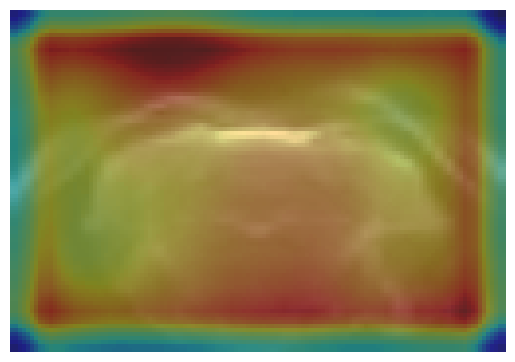

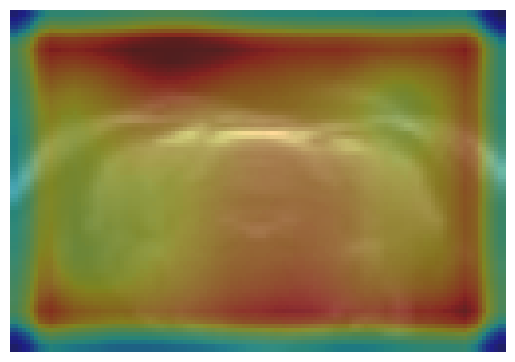

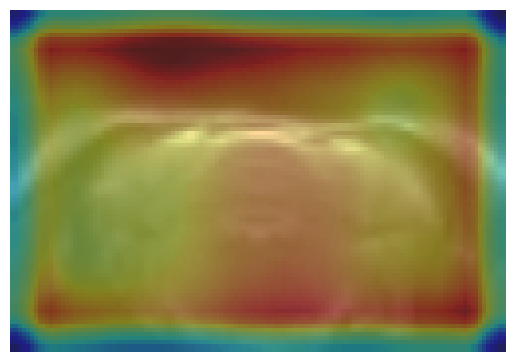

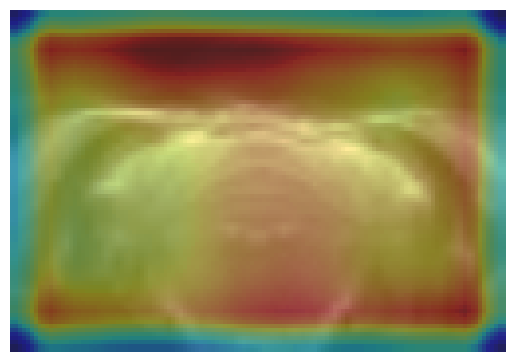

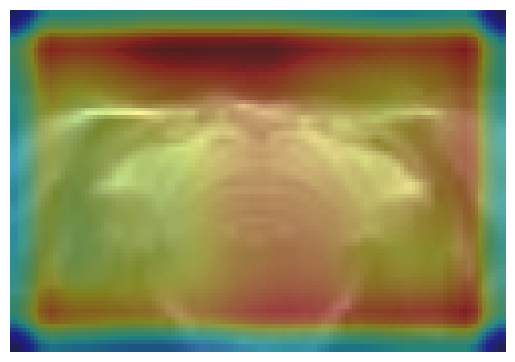

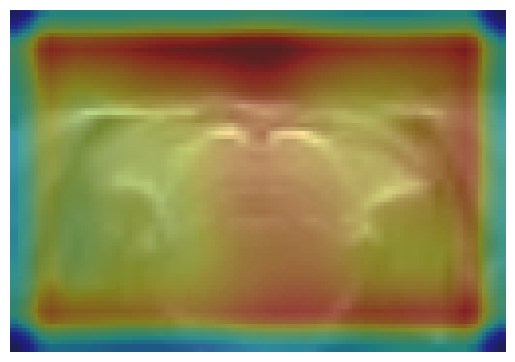

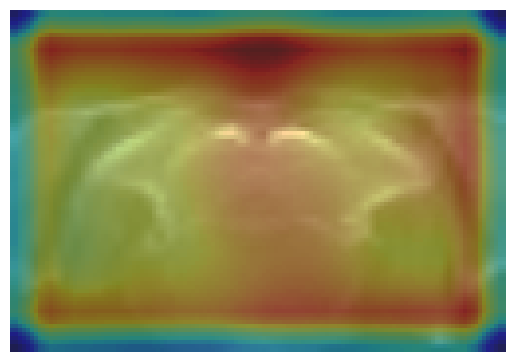

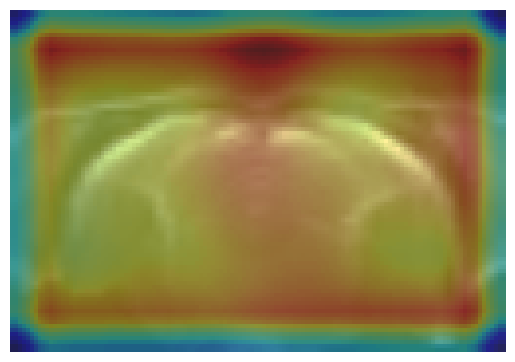

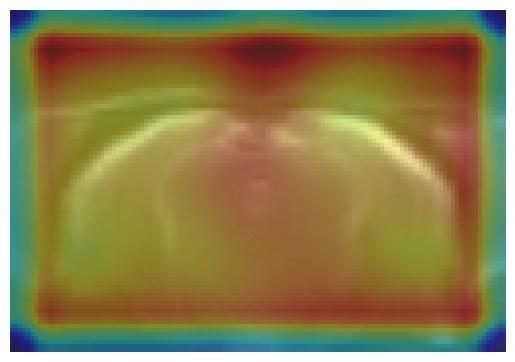

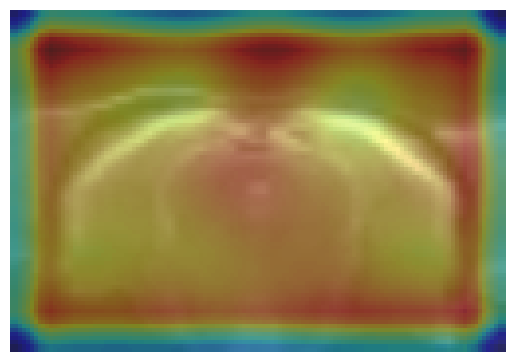

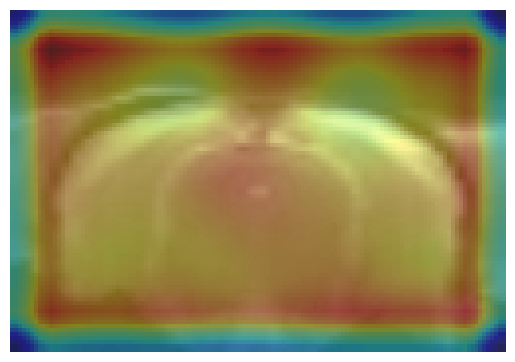

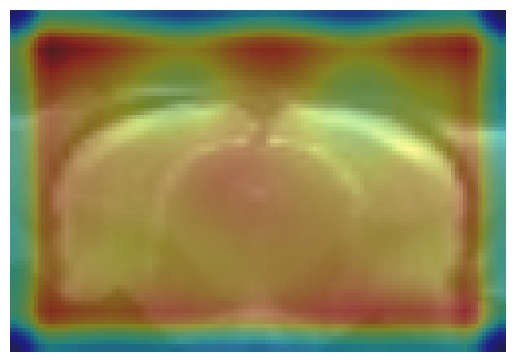

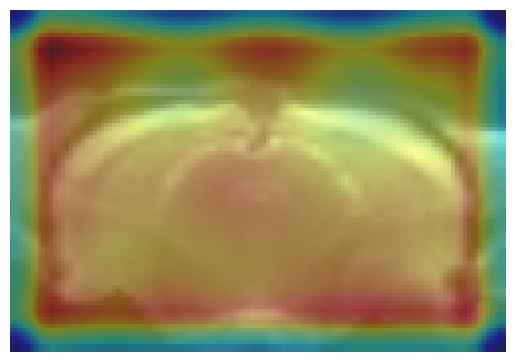

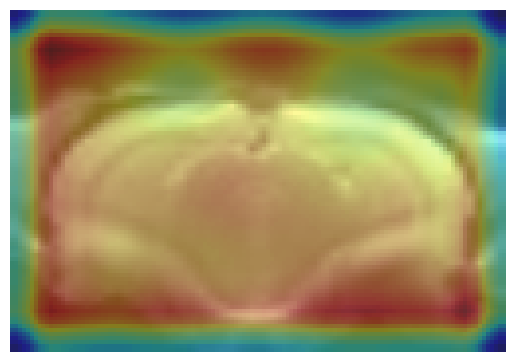

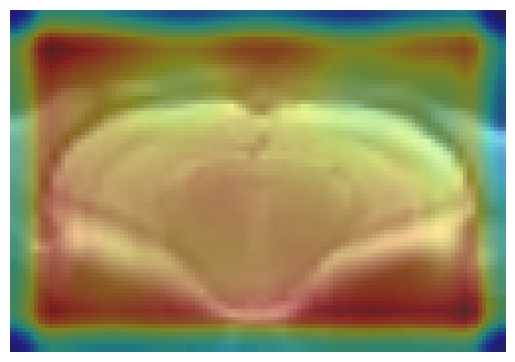

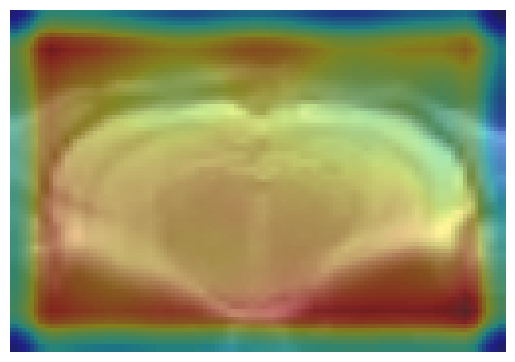

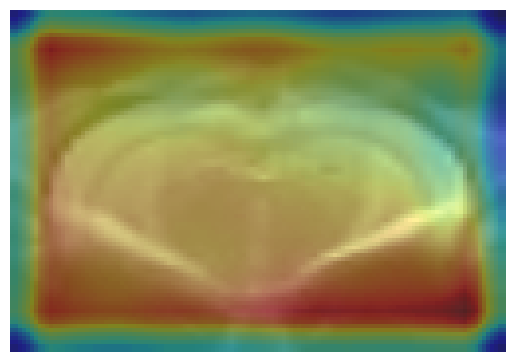

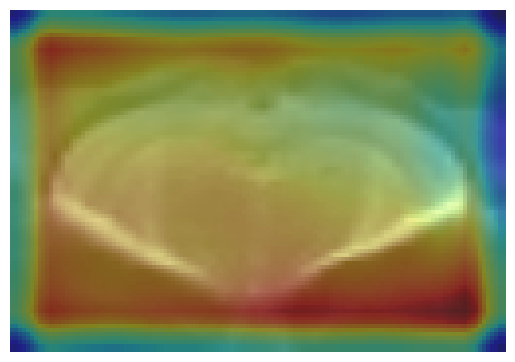

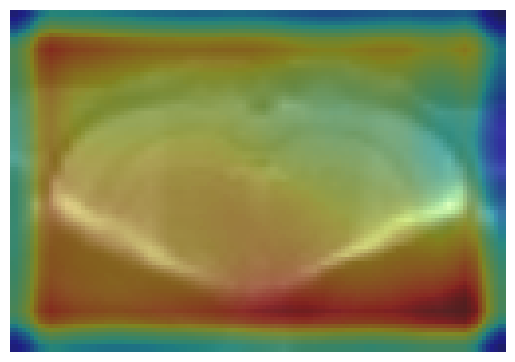

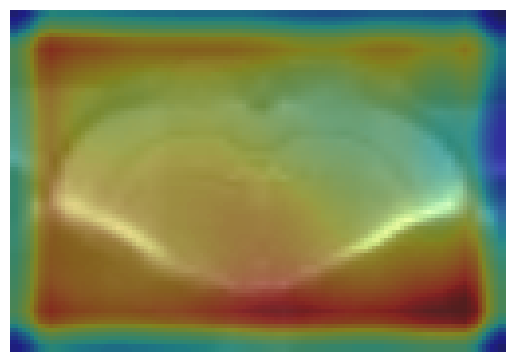

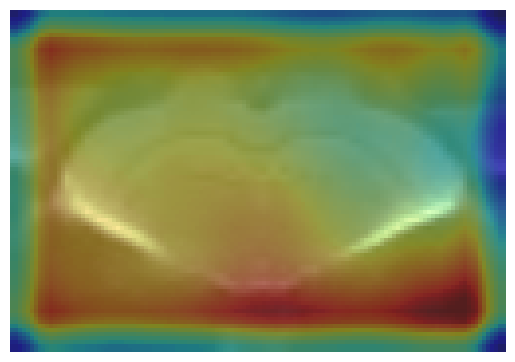

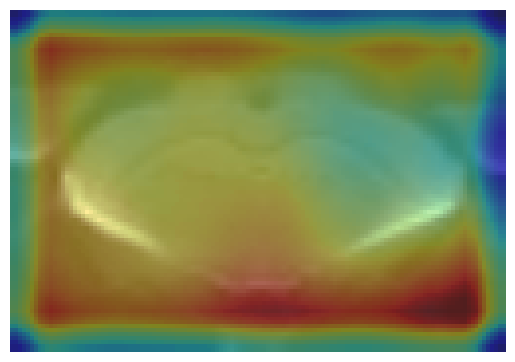

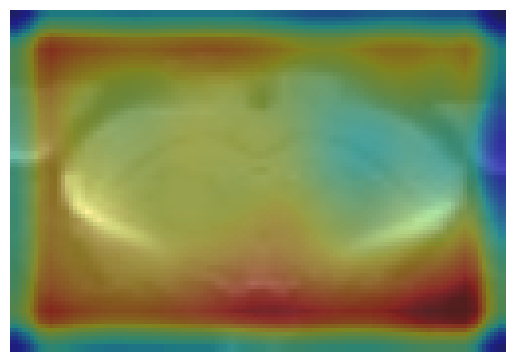

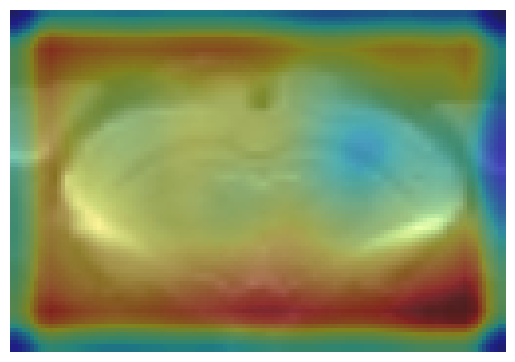

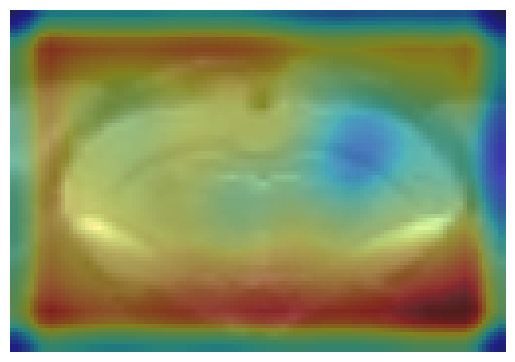

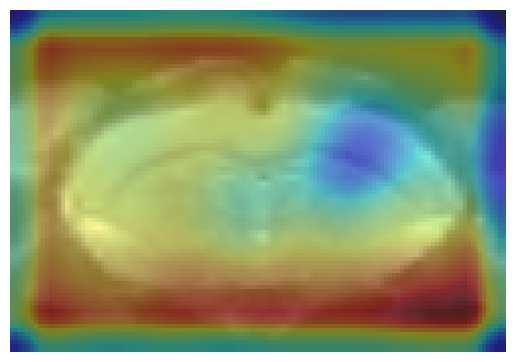

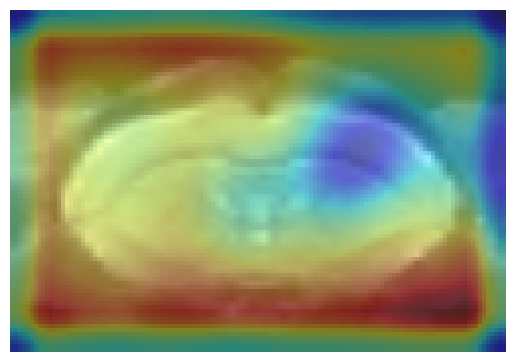

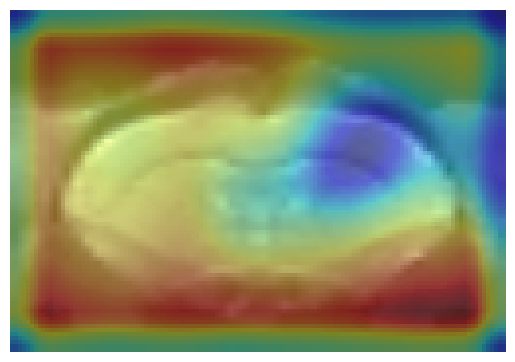

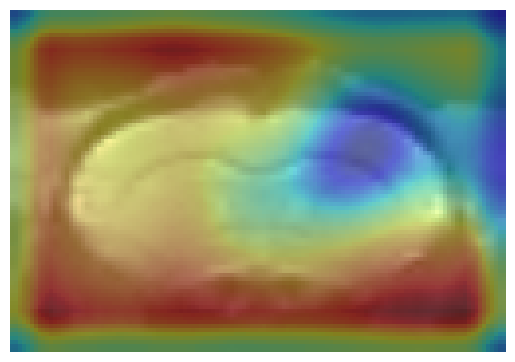

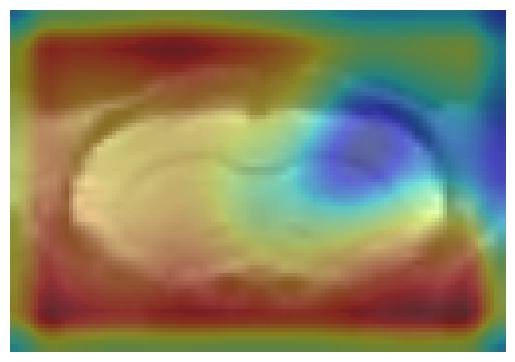

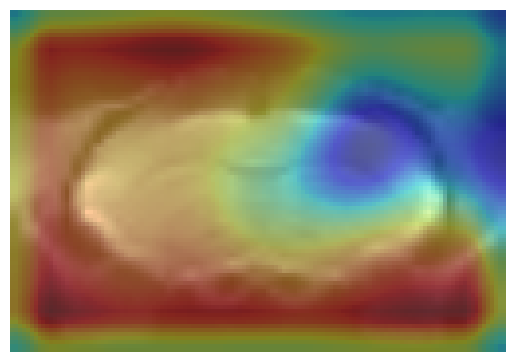

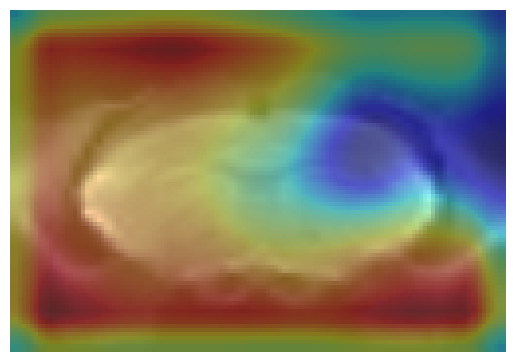

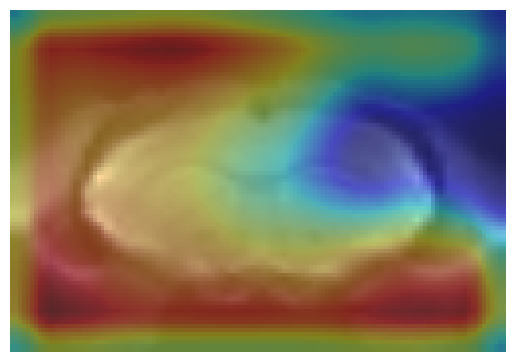

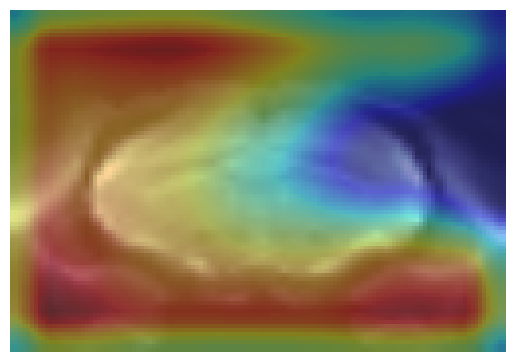

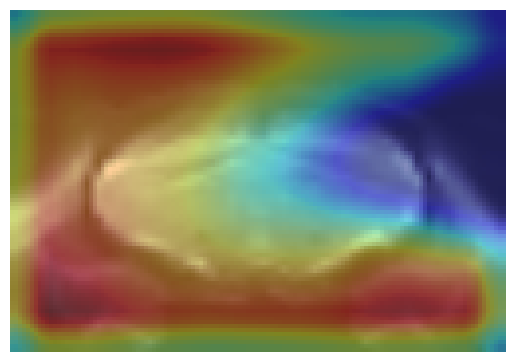

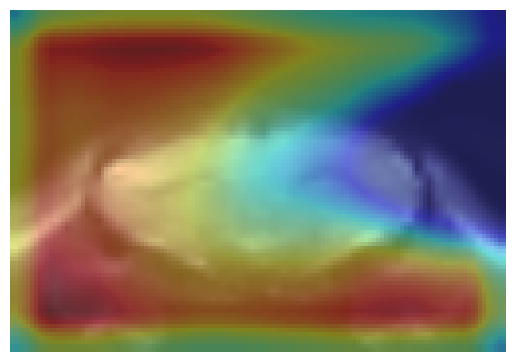

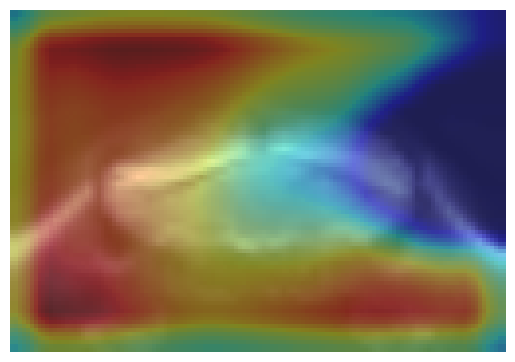

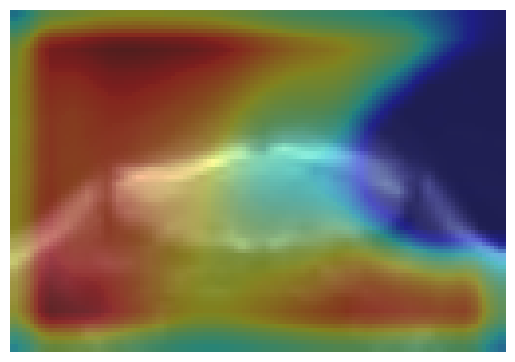

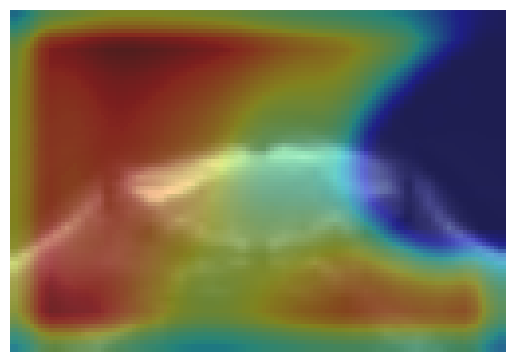

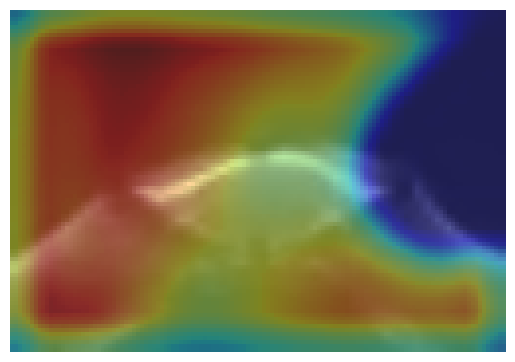

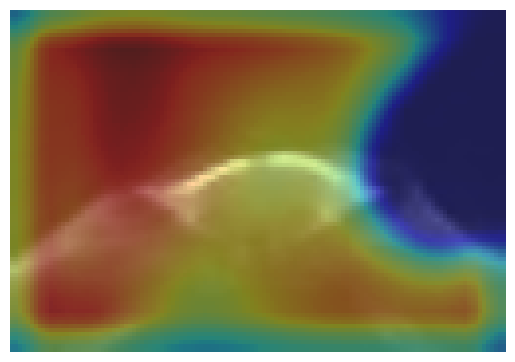

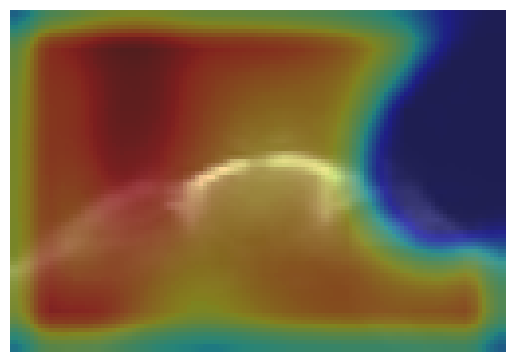

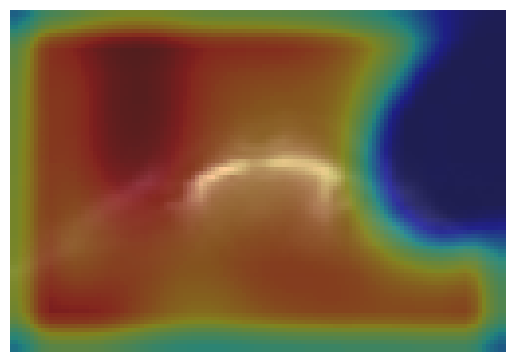

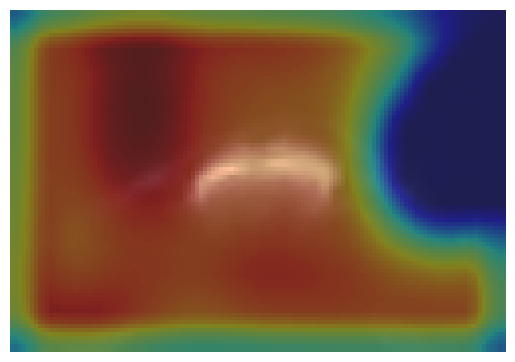

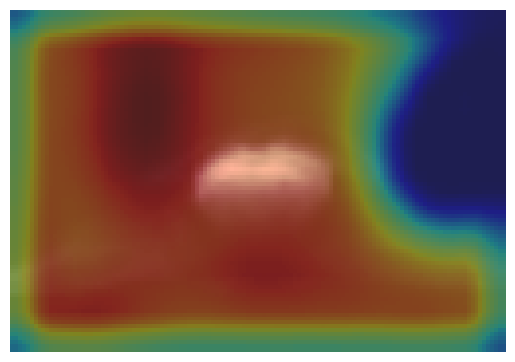

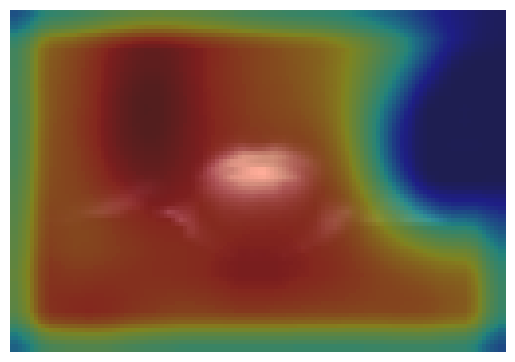

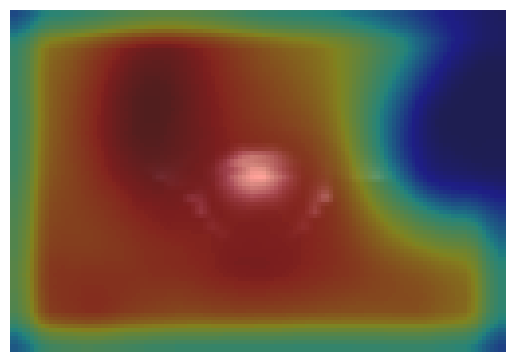

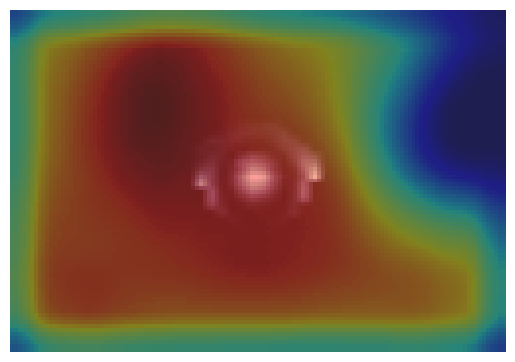

IndexError: index 65 is out of bounds for axis 1 with size 65

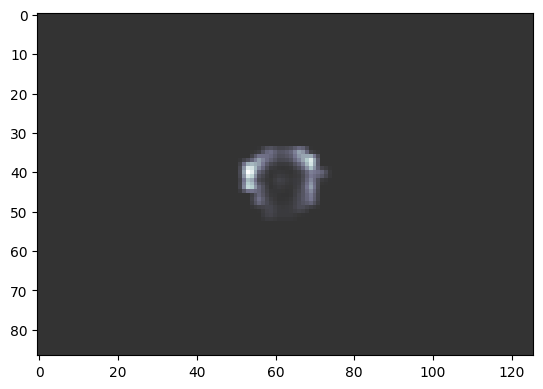

In [9]:

 # 80% train y val y 20% test
'''sub_trainval, sub_test, y_trainval, y_test = train_test_split(
    subjects, labels, test_size=0.2, random_state=42, stratify=labels
)'''

n_bootstraps= 1
for boot in range(n_bootstraps): 
    print(f"\n=== Bootstrapping Run {boot+1}/{n_bootstraps} ===")

    # Resample subjects + labels con reemplazo
    boot_subjects, boot_labels = resample(
     subjects, labels, replace=True, random_state=42+boot
    )

    sub_trainval, sub_test, y_trainval, y_test = train_test_split(
    boot_subjects, boot_labels, test_size=0.2, random_state=42, stratify=labels
)

    kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

    scores, histories = list(), list()
    run = 1
    for train_ix, val_ix in kfold.split(sub_trainval, y_trainval):
        print("Run #",run)
        sub_train, sub_val = boot_subjects[train_ix], boot_subjects[val_ix]
        y_train, y_val     = boot_labels[train_ix], boot_labels[val_ix]

        sub_test, y_test = sub_test, y_test

        

        # Set default values
        config_defaults = {
            "batch": 4,
        }
        # Initialize wandb with a sample project name
        wandb.init(project="Male vs Female(CPH)", notes="FOLD "+str(run)+".  Male-W7 vs Female-W7. Rest-approach on DIST data. GPT recommendations. 15 epoch. Just z-scoring and applying RandomFlip. All layers gradcam. pooling just on first block. lr = 1e-6",
                config=config_defaults)

        # Specify the other hyperparameters to the configuration.
        wandb.config.epochs = 15 #antes 15
        wandb.config.sub_batch = 30
        wandb.config.sub_batch_ts = 30
        wandb.config.subjects = subjects
        wandb.config.architecture_name = "VGG16_3D"
        wandb.config.dataset_name = "Male vs Female(CPH[w7])-Rest-approach_DIST-data"
        wandb.config.CNN_blocks = 5
        wandb.config.sessions = sessions
        wandb.config.vols_per_session_tr = 570 #570
        wandb.config.vols_per_session_ts = 570 #570
        wandb.config.initial_learning_rate = 1e-5
        #wandb.config.lr_decay_rate = 0.95
        wandb.config.optimizer = "Adam"
        
        #
        val_size = max(2, int(round(0.1 * len(train_ix))))
    
        sub_train, sub_val, y_train, y_val = train_test_split(
            sub_trainval[train_ix], y_trainval[train_ix],
            test_size=val_size,  # test_size se refiere a la validacion
            random_state=42, stratify=y_trainval[train_ix]
        )

        sub_test, y_test = sub_test, y_test
        #
        
        CPHclassTrain = FILES_and_LABELS(sub_train, sessions, MRI_type, functional_type)
        CPHclassTest = FILES_and_LABELS(sub_test, sessions, MRI_type, functional_type)
        CPHclassval = FILES_and_LABELS(sub_val, sessions, MRI_type, functional_type)
            
        X_train = CPHclassTrain.get_mask_and_bold()
        X_test = CPHclassTest.get_mask_and_bold()
        X_val = CPHclassval.get_mask_and_bold()

        print("sub train:")
        print(np.array(X_train)[:,0])
        print("sub test:")
        print(np.array(X_test)[:,0])
        print("sub val:")
        print(np.array(X_val)[:,0])

        print("# sesiones Train",len(X_train))
        print("# sesiones Test",len(X_test))
        print("# sesiones Val",len(X_val))
        
        traingen = CustomDataGen(X_train, batch_size=wandb.config.batch, subbatch_size=wandb.config.sub_batch,
                                format = "just_brain", vols = wandb.config.vols_per_session_tr,
                                num_class = 2, classes = "sex", augmentation = True, functional_type = "rest")
        traingen.on_epoch_end()
        #Es necesario que la division entre X_test y batch_size tenga un modulo igual a 0. 
        #De otra manera el ultimo batch no lo utiliza al utilizar .predict
        testgen  = CustomDataGen(X_test, batch_size=1,subbatch_size=wandb.config.sub_batch_ts,
                                format = "just_brain", vols= wandb.config.vols_per_session_ts,
                                num_class = 2, classes = "sex",shuffle=False, functional_type = "rest")
        valgen  = CustomDataGen(X_val, batch_size=len(X_val),subbatch_size=30, format = "just_brain",vols=570, augmentation = True, num_class = 2,
                                classes = "sex", functional_type = "rest")
        
        #getting model 3D CNN
        #callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, min_delta=0.0001)
        print("Starting VGG 16 3D-----------------------------------------------------")
        tf.keras.backend.clear_session()
        gc.collect()

        #transfer learning
        layers = [l for l in CNN.layers]
            
        for i in range(len(baseModel.layers)):
            layers[i].set_weights(baseModel.layers[i].get_weights())
            
        """
        lr_schedule = ExponentialDecay(wandb.config.initial_learning_rate,
                                    decay_steps=int((wandb.config.vols_per_session_tr/wandb.config.sub_batch)*len(X_train)),
                                    decay_rate=wandb.config.lr_decay_rate, staircase=True)
        """
        CNN.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=wandb.config.initial_learning_rate),
                        metrics=["Accuracy"])

        checkpoint_filepath = os.getcwd()+"/"+wandb.run.name
        #'/tmp/ckpt/MalevsFemale(CPH)_3D-VGG16_flips/'+wandb.run.name
        
        model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min',
                                                                save_best_only=True)
        
        start_time = datetime.now()
        
        print("Training")
        
        history = CNN.fit(traingen, epochs=wandb.config.epochs, validation_data = valgen, shuffle=True,
                        callbacks=[WandbCallback(monitor='val_loss',mode="min",save_model=(False)),model_checkpoint_callback])
        
        end_time = datetime.now()
        print('Duration (CNN): {}'.format(end_time - start_time))

        y_test=[]
        x_vols = []
        for i in range(int(len(X_test)*(wandb.config.vols_per_session_ts/wandb.config.sub_batch_ts))):
            x,y = testgen[i]
            y_test.extend(y)
            x_vols.extend(x)
        y_test = np.argmax(y_test, axis=1)

        
        print("predicts CNN")
        preds = tf.cast(tf.argmax(CNN.predict(testgen), axis=1), tf.int32)

        #Wrong predicted subjects
        wrong_labeled_subj = mislabeled_subj(y_test, preds, X_test, wandb.config.vols_per_session_ts)

        print("mislabeled subjects:\n",wrong_labeled_subj)
        
        print("evaluating CNN")
        _,acc = CNN.evaluate(testgen, verbose=1)
        
        scores.append(acc)
        histories.append(history)

        #GradCam
        all_layers = [layer.name for layer in reversed(CNN.layers) if len(layer.output_shape) == 5 and (layer.__class__.__name__ == 'ReLU' or isinstance(layer, tf.keras.layers.Conv3D))]
        
        index_male = index_for_gradcam(0,y_test,preds)
        index_female = index_for_gradcam(1,y_test,preds)

        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

        if index_male is None:
            index_male=0
            print("No se encontró ningún sujeto male correctamente clasificado")
            
        heatmap_male = make_gradcam_heatmap(np.expand_dims(x_vols[index_male], axis=0), CNN, all_layers[0])
        resized_heatmap_male = get_resized_heatmap(heatmap_male, np.shape(x_vols[index_male]))
        gradcam_male = create_animation(x_vols[index_male], 'Male', heatmap=resized_heatmap_male)
        name_ani_male = "GradCam_male(malevsfemale-CPH)-"+wandb.run.name+".mp4"
        gradcam_male.save(name_ani_male, writer=writer)

        #GradCam average all conv layers
        print("GradCam All ConvLayers-male")

        all_layers_gradcam_male = fuse_layers(all_layers, CNN, x_vols, index_male, emphasize=False)
        all_layers_animation_male = create_animation(x_vols[index_male], 'All_layers_GradCam_male', heatmap=all_layers_gradcam_male)
        name_all_male = 'All_layers_GradCam_male'+wandb.run.name+'.mp4'
        all_layers_animation_male.save(name_all_male, writer=writer)

        #males
        if not os.path.exists(os.getcwd()+"/"+wandb.run.name+"/male"): 
            # if the demo_folder directory is not present  
            # then create it. 
            os.makedirs(os.getcwd()+"/"+wandb.run.name+"/male")
        

        for i in range(rabies_vol.shape[1]):
            plt.imshow(cv2.resize(np.rot90(rabies_vol[:,i,:]),dsize=(126,87)), alpha=0.8, cmap='bone')
            # over the cam output
            plt.imshow(cv2.resize(np.rot90(resized_heatmap_male[:,i,:]),dsize=(126,87)), alpha=0.4,cmap='jet')
            plt.axis('off')
            # display the image
            name = str(i)+".png" 
            plt.savefig(os.getcwd()+"/"+wandb.run.name+"/male/"+name)
            plt.show()
    
    
        full_grad_male = np.zeros((48,81,48))
        full_grad_male[3:45,4:69,7:36] = resized_heatmap_male
        np.save(os.getcwd()+"/"+wandb.run.name+"/male/Array_GradCam-M", full_grad_male)
        
        wandb.log({'GradCam_Male-coronal': wandb.Video(name_ani_male),
            'GradCam_Male_all-layers': wandb.Video(name_all_male),
            'GradCam-per_frames-male': wandb.Image(grad_cam_per_frames(x_vols[index_male],resized_heatmap_male, 150))})

        if index_female is None:
            index_female=0
            print("No se encontró ningún sujeto female correctamente clasificado")
            
        heatmap_female = make_gradcam_heatmap(np.expand_dims(x_vols[index_female], axis=0), CNN, all_layers[0]) 
        resized_heatmap_female = get_resized_heatmap(heatmap_female, np.shape(x_vols[index_female]))
        gradcam_female = create_animation(x_vols[index_female], 'Female', heatmap=resized_heatmap_female)
        name_ani_female = "GradCam_female(malevsfemale-CPH)-"+wandb.run.name+".mp4"
        gradcam_female.save(name_ani_female, writer=writer)
    
        #GradCam average all conv layers
        print("GradCam All ConvLayers-female")
    
        all_layers_gradcam_female = fuse_layers(all_layers, CNN, x_vols, index_female, emphasize=False)
        all_layers_animation_female = create_animation(x_vols[index_female], 'All_layers_GradCam_female', heatmap=all_layers_gradcam_female)
        name_all_female = 'All_layers_GradCam_female'+wandb.run.name+'.mp4'
        all_layers_animation_female.save(name_all_female, writer=writer)
    
        #Save frame by frame of gradcam
        #Females
        if not os.path.exists(os.getcwd()+"/"+wandb.run.name+"/female"): 
            # if the demo_folder directory is not present  
            # then create it. 
            os.makedirs(os.getcwd()+"/"+wandb.run.name+"/female")
        
        for i in range(rabies_vol.shape[1]):
            plt.imshow(cv2.resize(np.rot90(rabies_vol[:,i,:]),dsize=(126,87)), alpha=0.8, cmap='bone')
            # over the cam output
            plt.imshow(cv2.resize(np.rot90(resized_heatmap_female[:,i,:]),dsize=(126,87)), alpha=0.4,cmap='jet')
            plt.axis('off')
            # display the image
            
            name = str(i)+".png" 
            plt.savefig(os.getcwd()+"/"+wandb.run.name+"/female/"+name)
            plt.show()
    
        
        #get gradCams with the shape of the original volumes before crop
        full_grad_female = np.zeros((48,81,48))
        full_grad_female[3:45,4:69,7:36] = resized_heatmap_female
        np.save(os.getcwd()+"/"+wandb.run.name+"/female/Array_GradCam-F", full_grad_female)
        wandb.log({'GradCam-Female-coronal': wandb.Video(name_ani_female),
            'GradCam-Female_all-layers': wandb.Video(name_all_female),
            'GradCam-per_frames-female': wandb.Image(grad_cam_per_frames(x_vols[index_female],resized_heatmap_female, 150))})
        

        print("CM CNN")
        cm = confusionmatrix(y_test, preds)

        wandb.log({'test_acc': float(acc),
                'time_running': '{}'.format(end_time - start_time),
                'confution_matrix': wandb.Image(cm),
                'mislabeled_subj':wrong_labeled_subj})
        

        run = run + 1
            
    print("histories and scores from VGG 16 M2D") 
    summarize_diagnostics(histories)
    summarize_performance(scores)

    wandb.finish()